In [2]:
import torch

import pickle

import sys
import os

model_path = "models/model400"

from cell_dataset import CellGraphDataset
from cell_utils import  make_animation
from cell_training import run_single, run_single_recursive
from cell_model import GraphEvolution

import matplotlib.pyplot as plt

import os, psutil
process = psutil.Process(os.getpid())
print("Using : ", process.memory_info().rss // 1000000)  # in megabytes 
print("Available : ", process.memory_info().vms  // 1000000)  # in megabytes 

print(torch.cuda.is_available())

from genericpath import exists

#https://github.com/clovaai/AdamP
from adamp import AdamP

sys.path.append('/home/nstillman/1_sbi_activematter/cpp_model')
try :
    import allium
except :
    print("Could not import allium")

Using :  425
Available :  8297
True


In [3]:
load_all = True

if load_all : 
    if os.path.exists("data/training.pkl") :
        with open("data/training.pkl", "rb") as f:
            data_train = pickle.load(f)
    if os.path.exists("data/testing.pkl") :
        with open("data/testing.pkl", "rb") as f:
            data_test = pickle.load(f)
else : 
    #path = "data/" #local
    path = "/scratch/users/nstillman/data-cpp/" #remote

    data_test = CellGraphDataset(root=path + 'test', max_size=5, inmemory=True, bg_load=False, wrap=True, T_limit=16)
    print("Test data length : ", data_test.len())
    
    data_val = CellGraphDataset(root=path + 'valid', max_size=50, inmemory=True, bg_load=False, wrap=True, T_limit=128)
    print("Validation data length : ", data_val.len())

    override = True #make this true to always use the same ones

    if override :
        data_test.save_or_load_if_exists("test_paths.pkl")
        data_val.save_or_load_if_exists("val_paths.pkl")

In [4]:
#INFO : if bg_load is True, this starts the loading, if skipped, bg_loading will take place as soon as a get is called
rval, edge_index, edge_attr, batch_edge, border, params = data_test.get(0)

In [5]:
model = GraphEvolution(in_channels=9, out_channels=4, hidden_channels=32, dropout=0.01, edge_dim=2, messages=5)
if exists(model_path + ".pt") :
    with open(model_path + ".pt", "rb") as f:
        model.load_state_dict(torch.load(f))
        #since we loaded the state dict, we need to recompile the model
        print("Loaded model from ", model_path)
     

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loaded model from  models/model400


torch.Size([14, 327, 2]) torch.Size([14, 327, 2])


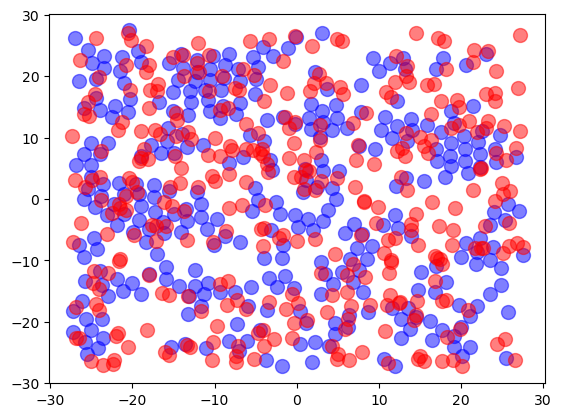

In [6]:
loss, out, x = run_single_recursive(model.to(device), data_test, 0, device, output=True)
print(out.shape, x.shape)

with open("result_recursive.pkl", "wb") as f:
    pickle.dump((out, x), f)

t = 10
fig = plt.figure()

#now plot the graph as bubbles to show the difference between the two
plt.scatter(x[t, :,0],x[t, :,1], s=100, c='b', alpha=0.5)
plt.scatter(out[t, :,0],out[t, :,1], s=100, c='r', alpha=0.5)

plt.close()

#show an arrow for the speed
#plt.quiver(x[t, :, 0], x[t, :, 1], x[t, :, 2], x[t, :, 3],color='b', alpha=0.5)
#plt.quiver(out[t, :, 0], out[t, :, 1], out[t, :, 2], out[t, :, 3],color='r', alpha=0.5)

tensor(0.0258, device='cuda:0', grad_fn=<MeanBackward0>)


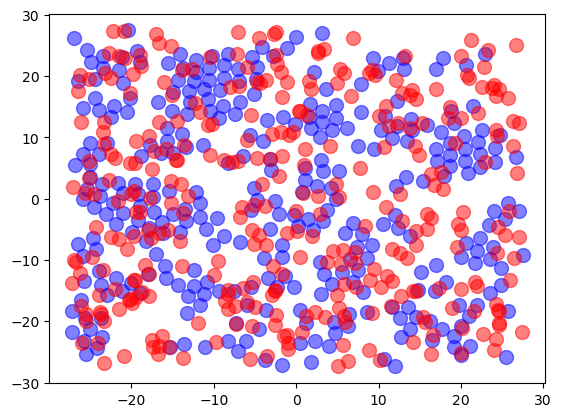

In [7]:
loss, out, x = run_single(model.to(device), data_test, 0, device, output=True)

print(loss)

with open("result.pkl", "wb") as f:
    pickle.dump((out, x), f)

t = 10
fig = plt.figure()

#now plot the graph as bubbles to show the difference between the two
plt.scatter(x[t, :,0],x[t, :,1], s=100, c='b', alpha=0.5)
plt.scatter(out[t, :,0],out[t, :,1], s=100, c='r', alpha=0.5)

plt.close()
#show an arrow for the speed
#plt.quiver(x[t, :, 0], x[t, :, 1], x[t, :, 2], x[t, :, 3],color='b', alpha=0.5)
#plt.quiver(out[t, :, 0], out[t, :, 1], out[t, :, 2], out[t, :, 3],color='r', alpha=0.5)

In [ ]:
raise Exception("Need ffmpeg to continue")

In [ ]:
from cell_utils import  make_animation

result_name = "./result_recursive.pkl"
animation_name = "./animation_recursive.mp4"
make_animation(result_name, animation_name, show_speed=False)

result_name = "./result.pkl"
animation_name = "./animation.mp4"
make_animation(result_name, animation_name, show_speed=False)

In [ ]:
from cell_utils import singleCellTrajectoryAnimation

result_name = "./result_recursive.pkl"
animation_name = "./animation_recursive_traj.mp4"
singleCellTrajectoryAnimation(result_name, animation_name, show_speed=False)

result_name = "./result.pkl"
animation_name = "./animation_traj.mp4"
singleCellTrajectoryAnimation(result_name, animation_name, show_speed=False)